## Getting Started with PyTorch on Intel GPUs

### Introduction:

Welcome to this Jupyter Notebook tutorial on getting started with PyTorch on Intel GPUs! In this notebook, we'll explore the exciting new features and capabilities of PyTorch, specifically the support for Intel GPUs (XPUs). We've already set up the environment and installed PyTorch for you, so you can dive right into learning and experimenting.

> **Note**: Ensure that you have selected `pytorch_2.5` as the Jupyter kernel before proceeding.

In [53]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 170.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 164.1 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
import os
from PIL import Image
from torch.utils.data import Dataset

class FoodSegDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform or transforms.Compose([
          transforms.Resize((256, 256)), 
          transforms.ToTensor()
        ])
        # self.transform = None
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path = self.dataset[idx]['image']
        labels = self.dataset[idx]['classes_on_image']  # a list of numbers, where each number is 1-104

        # Load the images
        # print(type(image_path))  # Should be a string representing the file path
        # print(image_path)  # Check if the path is correct
        image = image_path.convert("RGB")
        # mask = Image.open(mask_path).convert("L")  # Assuming the mask is in grayscale

        # Create a one-hot encoded tensor for the labels
        filtered_labels = [label for label in labels if label != 0]  # remove 0, represents background in dataset

        label_tensor = torch.zeros(104)  # Assuming 104 classes
        for label in filtered_labels:
            if 0 <= label < 104:  # Ensure label is within range
                label_tensor[label] = 1.0  # Set the corresponding index to 1
                
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        #print(f"in dataset labels shape {label_tensor.shape}")

        return image, label_tensor

In [18]:
def pad_collate(batch):
    # Find the maximum dimensions in the batch
    max_width = max([img.shape[2] for img, _ in batch])
    max_height = max([img.shape[1] for img, _ in batch])
    
    # Find the maximum label length in the batch
    max_length = max(len(label) for _, label in batch)
    
    # Pad all images to the max dimensions and labels to the max length
    processed_images = []
    labels = []
    for img, label in batch:
        if img is None or label is None:
            print("Found None value in batch.")
            continue  # Skip this entry

        # If the image is smaller, pad it
        if img.shape[1] < max_height or img.shape[2] < max_width:
            padding = (0, 0, max_width - img.shape[2], max_height - img.shape[1])
            img = transforms.functional.pad(img, padding)

        # If the image is larger, center-crop it
        elif img.shape[1] > max_height or img.shape[2] > max_width:
            img = transforms.functional.center_crop(img, (max_height, max_width))
            
        # Append the processed image and padded label to their respective lists
        processed_images.append(img)
        labels.append(label)

    # Convert processed images and labels to tensors
    processed_images_tensor = torch.stack(processed_images)
    labels = torch.stack(labels)

    #print(f"stacked image shape collate {processed_images_tensor.shape} labels shape {labels.shape}")

    

    return processed_images_tensor, labels

In [19]:
def initialize_model(num_classes):
  model = models.resnet18(pretrained=True)
  num_features = model.fc.in_features  
  model.fc = nn.Linear(num_features, num_classes)
  return model

In [20]:
def initialize_dataloaders():
    # Load dataset
    ds = load_dataset("EduardoPacheco/FoodSeg103")
    
    train_dataset = FoodSegDataset(ds['train'], transform=None)
    test_dataset = FoodSegDataset(ds['validation'], transform=None)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=pad_collate)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=pad_collate)
    train_len = len(train_loader)
    return train_loader, test_loader

In [21]:
def train(model, criterion, epoch, train_loader, optimizer):
    model = model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    print(f"Initiating training: Epoch {epoch}")

    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        with torch.autocast(device_type=device, dtype=torch.bfloat16, enabled=True):
            outputs = model(inputs)  # Output shape: (batch_size, 104)
            loss = criterion(outputs, labels.float())  # Ensure labels are float
            
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        predicted = (outputs > 0.4).float()  # Assuming binary classification, threshold at 0.4
        correct += (predicted == labels).sum().item()
        total += labels.numel()  # Total number of elements in the labels tensor
        
        running_loss += loss.item()
        if (i + 1) % 10 == 0:
            iteration_loss = loss.item()
            print(f"Iteration [{i + 1}/{len(train_loader)}], Loss: {iteration_loss:.4f}")

    epoch_loss = running_loss / (i + 1)
    accuracy = correct / total * 100  # Calculate accuracy as a percentage
    print(f"Epoch {epoch + 1} completed, Epoch Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

    if epoch == 0:
        filename = f'saved_model_epoch_{epoch}.h5'
        torch.save(model.state_dict(), filename)
        print(f'Model saved to {filename}')


In [22]:
import torch
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def eval(model, test_loader, criterion):
    model = model.eval()
    ingredient_indices = []
    threshold = 0.4  # You can adjust the threshold
    
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)  # Get true labels for loss calculation
            
            # Forward pass
            outputs = model(images)
            predictions = torch.sigmoid(outputs) > threshold  # Apply sigmoid and threshold to get binary predictions
            print(f"predictions shape eval {predictions.shape} predictions {predictions}")
            
            # Compute loss
            loss = criterion(outputs, labels.float())  # Use appropriate loss function
            total_loss += loss.item()
            
            # Calculate accuracy
            correct_predictions += (predictions == labels.bool()).sum().item()  # Count correct predictions
            total_samples += labels.numel()  # Total number of elements in labels
            print(f"eval: num correct predictions: {correct_predictions} num_total_samples {total_samples}")
            
            # Collect indices of identified ingredients
            indices = [torch.nonzero(pred).flatten().tolist() for pred in predictions]  # Get indices of identified ingredients
            ingredient_indices.extend(indices)  # Collect all indices
            
            # Collect all predictions and true labels for confusion matrix
            all_predictions.extend(predictions.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    
    # Calculate average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_samples

    '''
    # Log metrics to WandB
    wandb.log({
        "eval_loss": avg_loss,
        "eval_accuracy": accuracy
    })
    '''
    
    # Print metrics
    print(f"Eval Loss: {avg_loss:.4f}, Eval Accuracy: {accuracy:.2f}%")
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[f'Ingredient {i}' for i in range(cm.shape[1])],
                yticklabels=[f'Ingredient {i}' for i in range(cm.shape[1])])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

    # Example output for each image
    for idx, ingredients in enumerate(ingredient_indices):
        print(f"Identified ingredients for image {idx}: {ingredients}")  # Output identifier


Using device: cpu


/home/u0d56b234eb824167ff36ec96f89ac87/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/u0d56b234eb824167ff36ec96f89ac87/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initiating training: Epoch 0
Iteration [10/39], Loss: 0.5928
Iteration [20/39], Loss: 0.4338
Iteration [30/39], Loss: 0.3199
Epoch 1 completed, Epoch Loss: 0.4629, Accuracy: 90.60%
Model saved to saved_model_epoch_0.h5
predictions shape eval torch.Size([128, 104]) predictions tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])
eval: num correct predictions: 12604 num_total_samples 13312
predictions shape eval torch.Size([128, 104]) predictions tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False

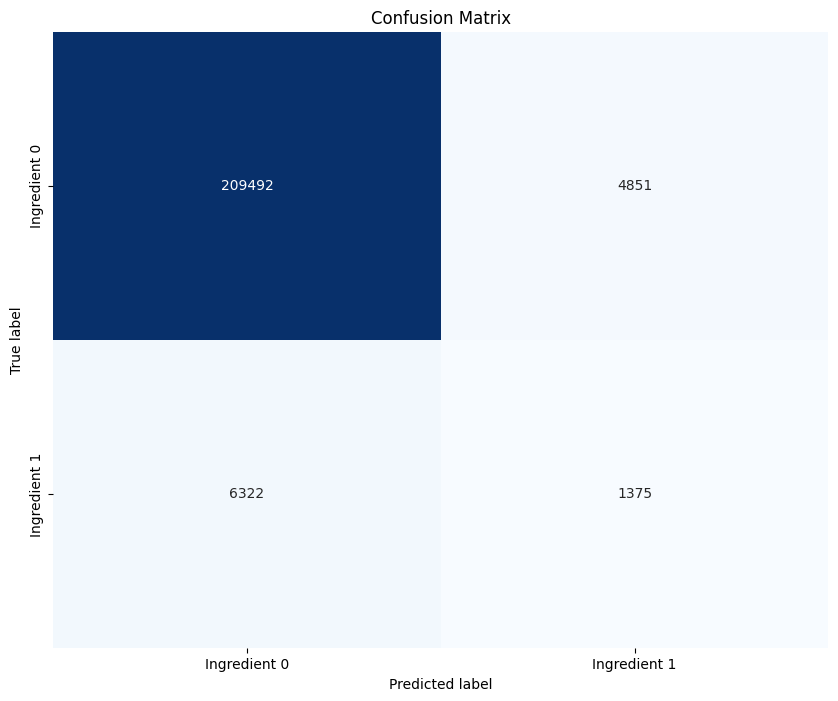

Identified ingredients for image 0: [48, 73, 84]
Identified ingredients for image 1: [31, 48, 73, 86, 95]
Identified ingredients for image 2: [53, 73, 86]
Identified ingredients for image 3: [14]
Identified ingredients for image 4: [31, 52, 53]
Identified ingredients for image 5: [53, 84]
Identified ingredients for image 6: [53, 73]
Identified ingredients for image 7: [31, 73, 95]
Identified ingredients for image 8: [48, 73, 84, 89]
Identified ingredients for image 9: [84]
Identified ingredients for image 10: [45, 95]
Identified ingredients for image 11: [31, 45, 53]
Identified ingredients for image 12: [53, 87, 89, 95]
Identified ingredients for image 13: [53]
Identified ingredients for image 14: [59]
Identified ingredients for image 15: [31, 73]
Identified ingredients for image 16: [8, 59, 95]
Identified ingredients for image 17: [48, 53, 59, 95]
Identified ingredients for image 18: [53]
Identified ingredients for image 19: [14, 31, 45, 53, 57]
Identified ingredients for image 20: [4

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import requests
import tqdm
from datasets import load_dataset
from torchvision.models.resnet import ResNet18_Weights
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# Device selection
device = 'xpu' if torch.xpu.is_available() else 'cpu'
print(f"Using device: {device}")

# Initialize dataloaders
train_loader, test_loader = initialize_dataloaders()

# Load the pre-trained model
model = initialize_model(104)  # 104 ingredients
model = model.to(device)


# Optimizer and loss
criterion = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss for multi-label classification
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 5

# Train and Eval Loop
for epoch in range(num_epochs):
    train(model, criterion, epoch, train_loader, optimizer)
    eval(model, test_loader, criterion)

wandb.finish()

In [1]:
pip install flask torch torchvision pillow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [14]:
# app.py
from flask import Flask, request, jsonify
from PIL import Image
import torch
import torchvision.transforms as transforms
import torch.nn as nn  # Import nn if using PyTorch nn.Module

# Define your model class (make sure this matches your training model)
class YourModel(nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()
        # Define your model layers here
        self.fc = nn.Linear(512, 10)  # Example layer; adjust as necessary

    def forward(self, x):
        # Define the forward pass
        return self.fc(x)

# Initialize Flask app
app = Flask(__name__)

# Load the model
model_path = 'saved_model_epoch_0.pt'  # Path to your saved model
model = YourModel()  # Create an instance of your model
state_dict = torch.load(model_path, map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=False)

# Remove unwanted keys
for key in list(state_dict.keys()):
    if 'fc.' in key:  # Adjust based on which keys you want to remove
        del state_dict[key]
model.load_state_dict(state_dict, strict=False)

model.load_state_dict(state_dict)  # Load the state dict into the model
model.eval()  # Set model to evaluation mode

# Define image preprocessing function
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Adjust based on your model input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize for your model
    ])
    
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Define the prediction route
@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No file provided'}), 400

    file = request.files['file']
    image = Image.open(file.stream).convert('RGB')  # Convert to RGB

    # Preprocess the image
    input_array = preprocess_image(image)

    # Use the model to make a prediction
    with torch.no_grad():
        output = model(input_array)
        
    # Process the output as per your model's output
    prediction = torch.argmax(output, dim=1).item()  # Get predicted class index
    
    return jsonify({'prediction': prediction})

# Run the Flask app
if __name__ == '__main__':
    app.run(port=5000)


/tmp/ipykernel_740627/3514240974.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.device('cpu'))


RuntimeError: Error(s) in loading state_dict for YourModel:
	size mismatch for fc.weight: copying a param with shape torch.Size([104, 512]) from checkpoint, the shape in current model is torch.Size([10, 512]).
	size mismatch for fc.bias: copying a param with shape torch.Size([104]) from checkpoint, the shape in current model is torch.Size([10]).